In [1]:
#import required classes and packages
import os
import cv2
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

from keras.applications import VGG19
from keras.applications import DenseNet121
from keras.applications import DenseNet169
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, load_model

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Guava Dataset Class Labels : "+str(labels))     

Guava Dataset Class Labels : ['Disease Free', 'Phytopthora', 'Red rust', 'Scab', 'Styler and Root']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (32, 32))#resize image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 527



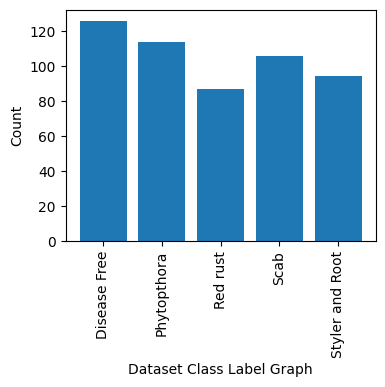

In [5]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Sample Processed Image')

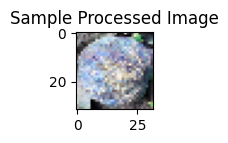

In [6]:
#display processed sample image
img = X[160]
plt.figure(figsize =(1, 1)) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Processed Image")

In [7]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 421
20% image used to train algorithms : 106


In [8]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [9]:
#function to calculate accuracy and other metrics
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 
Densenet121 Accuracy  :  66.98113207547169
Densenet121 Precision : 77.93548387096774
Densenet121 Recall    : 67.21438523162661
Densenet121 FScore    : 61.84256657299613


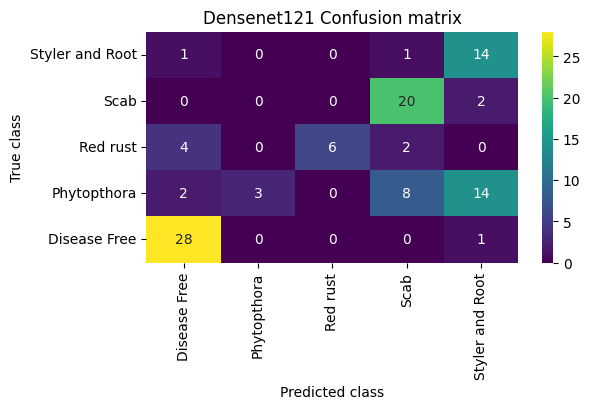

In [10]:
#training densenet121 using train features and then tested on test data
densenet = DenseNet121(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in densenet.layers:
    layer.trainable = False   
#get densenet output and then feed guava dataset features as transfer learning
headModel = densenet.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
#create model with densenet input and get trained on guava as the output
densenet_model = Model(inputs=densenet.input, outputs=headModel)
learning_rate = 0.01
epochs = 30
optimizer = Adam(learning_rate = learning_rate)
loss = BinaryCrossentropy()
#compile the model and then train and load it
densenet_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
if os.path.exists("model/densenet121_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/densenet121_weights.hdf5', verbose = 1, save_best_only = True)
    hist = densenet_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/densenet121_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    densenet_model.load_weights("model/densenet121_weights.hdf5")
#perform prediction on test data   
predict = densenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy and other metrics
calculateMetrics("Densenet121", predict, y_test1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
VGG19 Accuracy  :  96.22641509433963
VGG19 Precision : 96.36904761904763
VGG19 Recall    : 96.19107744107744
VGG19 FScore    : 96.2637420718816


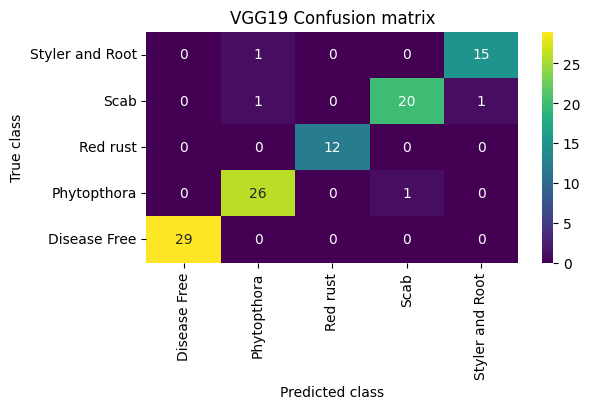

In [11]:
#train VGG19 on guava features
vgg19 = VGG19(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg19.layers:
    layer.trainable = False
headModel = vgg19.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
vgg19_model = Model(inputs=vgg19.input, outputs=headModel)
learning_rate = 0.01
epochs = 30
optimizer = Adam(learning_rate = learning_rate)
loss = BinaryCrossentropy()
#compile the model and then train and load it
vgg19_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
if os.path.exists("model/vgg_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/vgg_weights.hdf5', verbose = 1, save_best_only = True)
    hist = vgg19_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/vgg_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    vgg19_model.load_weights("model/vgg_weights.hdf5")
#perform prediction on test data   
predict = vgg19_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("VGG19", predict, y_test1)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002891463E8E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step 
DenseNet169 Accuracy  :  70.75471698113208
DenseNet169 Precision : 75.87179487179488
DenseNet169 Recall    : 71.64562289562288
DenseNet169 FScore    : 68.33698722618011


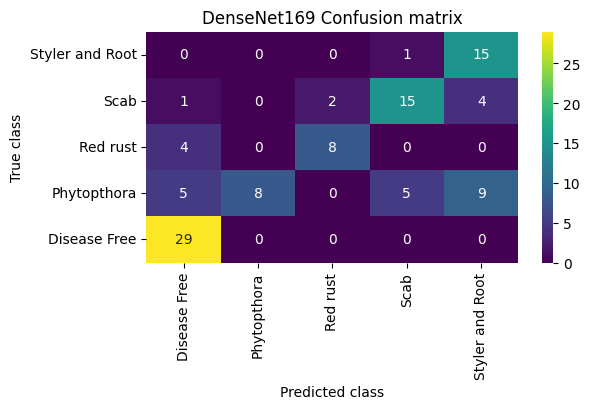

In [12]:
#train densenet169 using Guava dataset features
dn = DenseNet169(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in dn.layers:
    layer.trainable = False
headModel = dn.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
dn_model = Model(inputs=dn.input, outputs=headModel)
learning_rate = 0.01
epochs = 30
optimizer = Adam(learning_rate = learning_rate)
loss = BinaryCrossentropy()
#compile the model and then train and load it
dn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
if os.path.exists("model/dn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/dn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = dn_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/dn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    dn_model.load_weights("model/dn_weights.hdf5")
#perform prediction on test data 
predict = dn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("DenseNet169", predict, y_test1)

In [13]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['DenseNet121','Accuracy',accuracy[0]],['DenseNet121','Precision',precision[0]],['DenseNet121','Recall',recall[0]],['DenseNet121','FSCORE',fscore[0]],
                   ['VGG19','Accuracy',accuracy[1]],['VGG19','Precision',precision[1]],['VGG19','Recall',recall[1]],['VGG19','FSCORE',fscore[1]],
                   ['DenseNet169','Accuracy',accuracy[2]],['DenseNet169','Precision',precision[2]],['DenseNet169','Recall',recall[2]],['DenseNet169','FSCORE',fscore[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(10, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [ ]:
#display all algorithm performnace
algorithms = ['DenseNet121', 'VGG19', 'DenseNet169']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

In [ ]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = vgg19_model.predict(img)#now predict dog breed
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,200))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

In [ ]:
#call this function with test image to predict dog breed
predict("testImages/0.jpg")

In [ ]:
#call this function with test image to predict dog breed
predict("testImages/01.jpg")

In [ ]:
#call this function with test image to predict dog breed
predict("testImages/1.jpg")

In [ ]:
#call this function with test image to predict dog breed
predict("testImages/2.jpg")

In [ ]:
#call this function with test image to predict dog breed
predict("testImages/6.jpg")